In [1]:
# Import common libraries
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from random import random
# For disabling warning pop-ups
import warnings
warnings.simplefilter('ignore')
# Import for the data
import tensorflow.image as tfi
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img 
from tensorflow.keras.utils import img_to_array
# Import for the layers
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import Conv2DTranspose
from tensorflow_addons.layers import InstanceNormalization
# Import for the model functions
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.initializers import RandomNormal
# Import for the Optimizers
from tensorflow.keras.optimizers import Adam
# Import for the losses
from keras.losses import BinaryCrossentropy
# Import for the Model Viz
from tensorflow.keras.utils import plot_model

In [2]:
# Takes an image and plots it using Matplotlib
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Data Preparation

In [3]:
# Locating the datapath
root_horse_path = 'trainA'
root_zebra_path = 'trainB'
horse_paths = sorted(glob(root_horse_path + '/*.jpg'))[:1000]
zebra_paths = sorted(glob(root_zebra_path + '/*.jpg'))[:1000]

# A total of 1067 images are located

In [4]:
# Loading the images in the horse and zebra path
SIZE = 256
horse_images, zebra_images = np.zeros(shape=(len(horse_paths),SIZE,SIZE,3)), np.zeros(shape=(len(horse_paths),SIZE,SIZE,3))
for i,(horse_path, zebra_path) in tqdm(enumerate(zip(horse_paths, zebra_paths)), desc='Loading'):
    
    horse_image = img_to_array(load_img(horse_path))
    horse_image = tfi.resize(tf.cast(horse_image, tf.float32)/255., (SIZE, SIZE))
    
    zebra_image = img_to_array(load_img(zebra_path))
    zebra_image = tfi.resize(tf.cast(zebra_image,tf.float32)/255., (SIZE, SIZE))
    
    # as the data is unpaired so we don't have to worry about, positioning the images.
    
    horse_images[i] = horse_image
    zebra_images[i] = zebra_image

Loading: 1000it [00:07, 133.19it/s]


In [5]:
dataset = [horse_images, zebra_images]

# Data Pre-processing

In [6]:
# Pixel to pixel GAN
def ResidualBlock(filters, layer, index):
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv1".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization1".format(index))(x)
    x = ReLU(name="Block_{}_ReLU".format(index))(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv2".format(index))(x)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization2".format(index))(x)
    x = concatenate([x, layer], name="Block_{}_Merge".format(index))
    return x

In [7]:
# Main model architecture
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Encoder_{}_Conv".format(index))(layer)
    if norm:
        x = InstanceNormalization(axis=-1, name="Encoder_{}_Normalization".format(index))(x)
    if activation is not None:
        x = Activation(activation, name="Encoder_{}_Activation".format(index))(x)
    else:
        x = LeakyReLU( name="Encoder_{}_LeakyReLU".format(index))(x)
    return x

In [8]:
# Down Sample Layer
# Decreasing the input image size by 2
def upsample(filters, layer, size=3, strides=2, index=None):
    x = Conv2DTranspose(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Decoder_{}_ConvT".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Decoder_{}_Normalization".format(index))(x)
    x = ReLU( name="Encoder_{}_ReLU".format(index))(x)
    return x

In [9]:
# Up Sample Layer
# Increase the input image size by 2
def Generator(n_resnet=9, name="Generator"):
    inp_image = Input(shape=(SIZE, SIZE, 3), name="InputImage")         
    x = downsample(64, inp_image, size=7, strides=1, index=1)           
    x = downsample(128, x, index=2)                                  
    x = downsample(256, x, index=3)                                     
    for i in range(n_resnet):
        x = ResidualBlock(256, x, index=i+4)                             
    x = upsample(128, x, index=13)                                       
    x = upsample(64, x, index=14)                                       
    x = downsample(3, x, size=7, strides=1, activation='tanh', index=15) 
    model = Model(
        inputs=inp_image,
        outputs=x,
        name=name
    )
    return model

In [10]:
# Instead of batch normalization the instance normalization is going to be used
# The function of discriminator is whether the generated images are actually generated from the input image or not
def Discriminator(name='Discriminator'):
    init = RandomNormal(stddev=0.02)
    src_img = Input(shape=(SIZE, SIZE, 3), name="InputImage")     
    x = downsample(64, src_img, size=4, strides=2, index=1, norm=False) 
    x = downsample(128, x, size=4, strides=2, index=2)           
    x = downsample(256, x, size=4, strides=2, index=3)           
    x = downsample(512, x, size=4, strides=2, index=4)           
    x = downsample(512, x, size=4, strides=2, index=5)            
    patch_out = Conv2D(1, kernel_size=4, padding='same', kernel_initializer=init, use_bias=False)(x) 
    model = Model(
        inputs=src_img,
        outputs=patch_out,
        name=name
    )
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
        loss_weights=[0.5]
    )
    return model

# Training Functions

In [11]:
def CombineModel(g_model1, g_model2, d_model, name):
    g_model1.trainable = True
    d_model.trainable = False
    g_model2.trainable = False
    input_gen = Input(shape=(SIZE, SIZE, 3))
    gen_1_out = g_model1(input_gen)
    dis_out = d_model(gen_1_out)
    input_id = Input(shape=(SIZE, SIZE, 3))
    output_id = g_model1(input_id)   
    output_f = g_model2(gen_1_out)
    gen_2_out = g_model2(input_id)
    output_b = g_model1(gen_2_out)
    model = Model(
        inputs=[input_gen, input_id],
        outputs=[dis_out, output_id, output_f, output_b],
        name=name
    )
    model.compile(
        loss=['mse', 'mae', 'mae', 'mae'],
        loss_weights=[1,5,10,10],
        optimizer= Adam(learning_rate=2e-4, beta_1=0.5)
    )
    return model

In [12]:
# The combined model came from Discriminator and Generator
def generate_real_samples(n_samples, dataset):
    ix = np.random.randint(0,dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones(shape=(n_samples, 8, 8, 1))
    return X, y

In [13]:
def generate_fake_samples(g_model, dataset):
    X = g_model.predict(dataset)
    y = np.zeros(shape=(len(dataset), 8, 8, 1))
    return X, y

In [14]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = np.random.randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [15]:
def show_preds(gv1, gv2,n_images=1):
    for i in range(n_images):
        
        id = np.random.randint(len(horse_images))
        horse, zebra = horse_images[id], zebra_images[id]
        horse_pred, zebra_pred = gv2.predict(tf.expand_dims(zebra,axis=0))[0], gv1.predict(tf.expand_dims(horse,axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,4,1)
        show_image(horse, title='Original Horse')
        
        plt.subplot(1,4,2)
        show_image(zebra_pred, title='Generated Zebra')
        
        plt.subplot(1,4,3)
        show_image(zebra, title='Original Zebra')
        
        plt.subplot(1,4,4)
        show_image(horse_pred, title='Genrated Horse')
        
        plt.tight_layout()
        plt.show()

# Data Training

In [16]:
def train(d_model_A, d_model_B, genv1, genv2, cv1v2, cv2v1, epochs=10, chunk=5):
    n_epochs, n_batch = epochs, 1
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    bat_per_epoch = int(len(trainA)/n_batch)
    n_steps = bat_per_epoch
    for j in tqdm(range(1,epochs+1), desc="Epochs"):
        for i in range(n_steps):
            X_realA, y_realA = generate_real_samples(n_batch, trainA)
            X_realB, y_realB = generate_real_samples(n_batch, trainB)
            X_fakeA, y_fakeA = generate_fake_samples(genv2, X_realB)
            X_fakeB, y_fakeB = generate_fake_samples(genv1, X_realA)
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolA, X_fakeB)
            gen_loss2, _, _, _, _ = cv2v1.train_on_batch(
                [X_realB, X_realA],
                [y_realB, X_realA, X_realB, X_realA]
            )
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            gen_loss1, _, _, _, _ = cv1v2.train_on_batch(
                [X_realA, X_realB],
                [y_realA, X_realB, X_realA, X_realB]
            )
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        if (j%chunk)==0:
            show_preds(genv1, genv2, n_images=1)
            genv1.save("GeneratorHtoZ.h5")
            genv2.save("GeneratorZtoH.h5")

# Data Evaluation

In [17]:
# Creating the generators.
gv1 = Generator(name="GeneratorAB")
gv2 = Generator(name="GeneratorBA")

# Discriminators.
dv1 = Discriminator(name="DiscriminatorA")
dv2 = Discriminator(name="DiscriminatorB")

# Combining the generators and discriminators
cv1v2 = CombineModel(gv1, gv2, dv2, name="GanAB")
cv2v1 = CombineModel(gv2, gv1, dv1, name="GanBA")

# Testing the Model

In [18]:
HtoZ_gen = load_model("imagetoimage-translation-cyclegan/GeneratorHtoZ.h5")
ZtoH_gen = load_model("imagetoimage-translation-cyclegan/GeneratorZtoH.h5")

1/1 [==============================] - 3s 3s/step


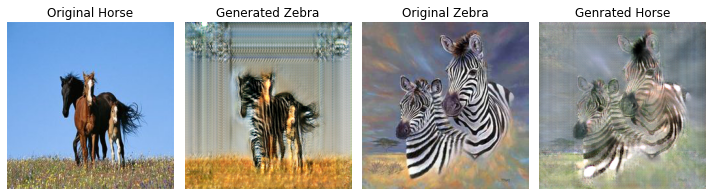

1/1 [==============================] - 1s 1s/step


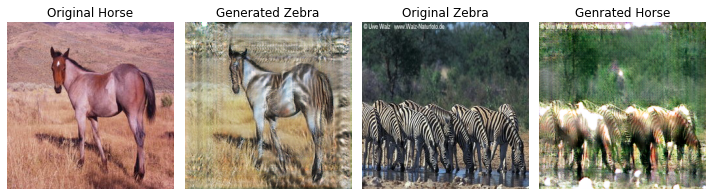

1/1 [==============================] - 1s 1s/step


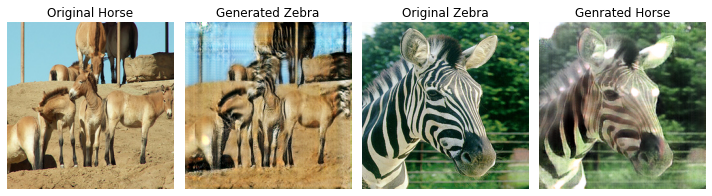

1/1 [==============================] - 1s 1s/step


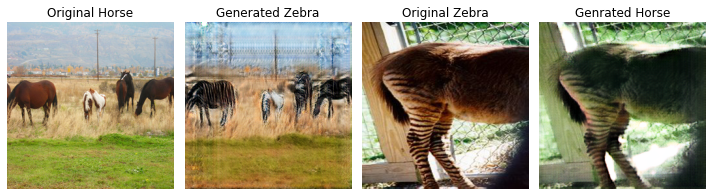

1/1 [==============================] - 1s 1s/step


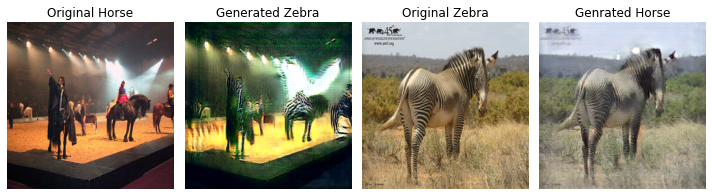

In [19]:
show_preds(HtoZ_gen, ZtoH_gen, n_images=5)

In [20]:
HtoZ_gen_25 = load_model("imagetoimage-translation-cyclegan/GeneratorHtoZ_25.h5")
ZtoH_gen_25 = load_model("imagetoimage-translation-cyclegan/GeneratorZtoH_25.h5")

1/1 [==============================] - 4s 4s/step


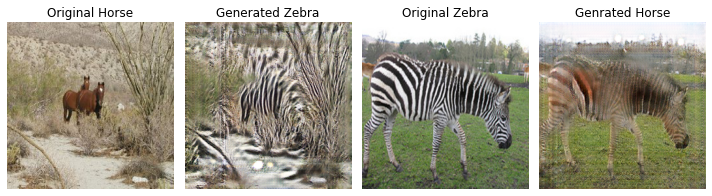

1/1 [==============================] - 2s 2s/step


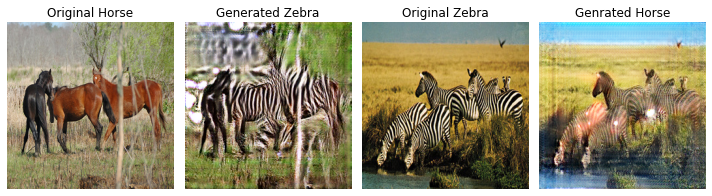

1/1 [==============================] - 1s 1s/step


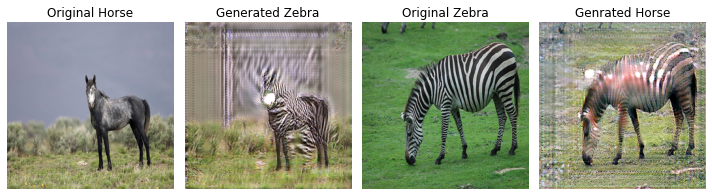

1/1 [==============================] - 2s 2s/step


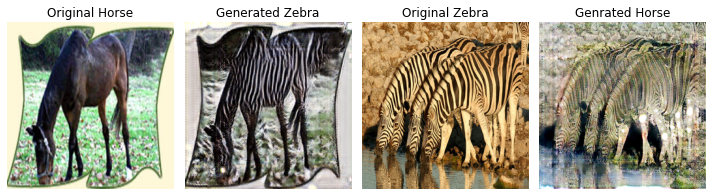

1/1 [==============================] - 2s 2s/step


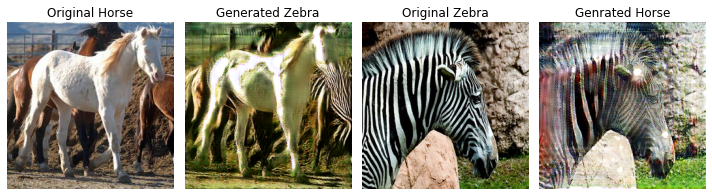

In [21]:
show_preds(HtoZ_gen_25, ZtoH_gen_25, n_images=5)

1/1 [==============================] - 2s 2s/step


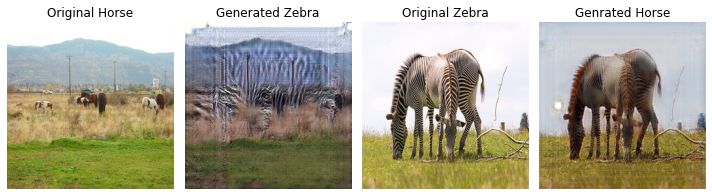

1/1 [==============================] - 2s 2s/step


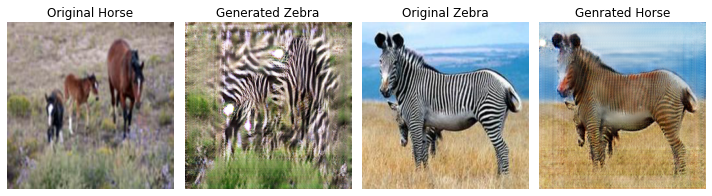

1/1 [==============================] - 1s 1s/step


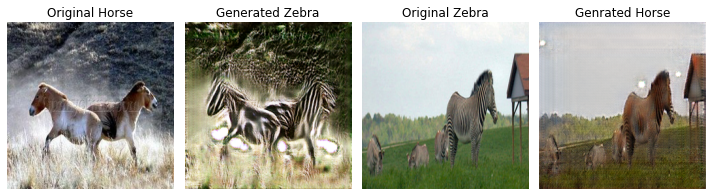

1/1 [==============================] - 1s 1s/step


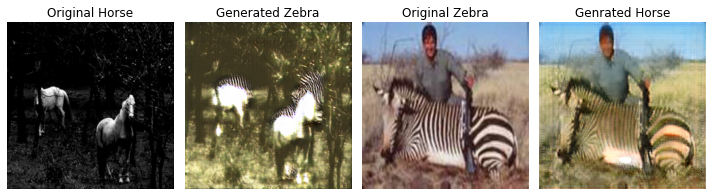

1/1 [==============================] - 1s 1s/step


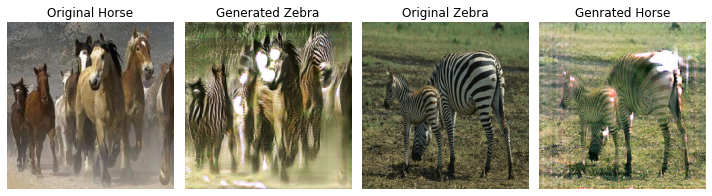

In [22]:
show_preds(HtoZ_gen_25, ZtoH_gen_25, n_images=5)

1/1 [==============================] - 2s 2s/step


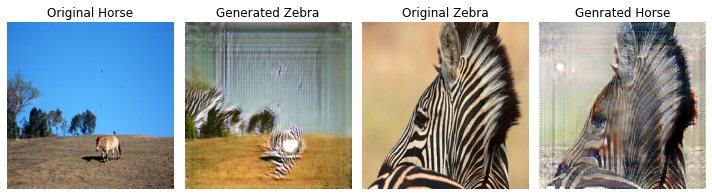

1/1 [==============================] - 1s 1s/step


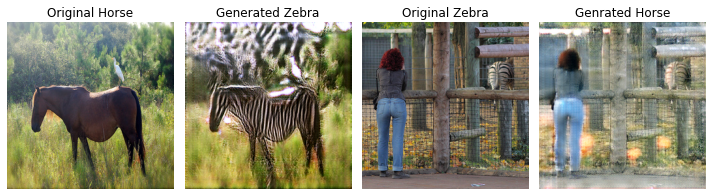

1/1 [==============================] - 1s 1s/step


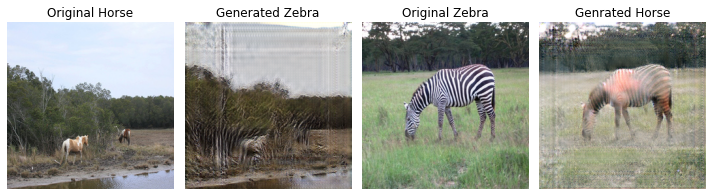

1/1 [==============================] - 1s 1s/step


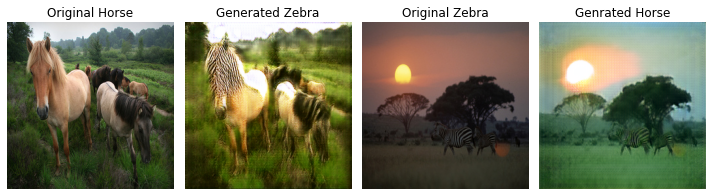

1/1 [==============================] - 1s 1s/step


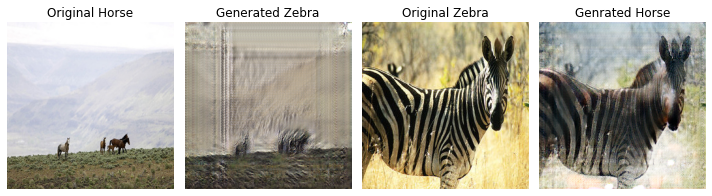

In [23]:
show_preds(HtoZ_gen_25, ZtoH_gen_25, n_images=5)